In [16]:
#Librerie importate
!pip install SimpleITK
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import requests, os
import pandas as pd

↓ Download: https://raw.githubusercontent.com/noemicosma-commits/EICA_ROI_UMG_project/main/img1SL.nrrd
Salvato: img1SL.nrrd

↓ Download: https://raw.githubusercontent.com/noemicosma-commits/EICA_ROI_UMG_project/main/img2SL.nrrd
Salvato: img2SL.nrrd

Lettura immagini...

Processing factor 1...
Processing factor 2...
Processing factor 4...
Processing factor 8...

RISULTATI FINALI

   factor      dice  hausdorff_max  avg_surface_distance
0       1  1.000000       0.000000              0.000000
1       2  0.975914      10.551133              0.036149
2       4  0.953896      16.830829              0.102861
3       8  0.921129      29.160001              0.259782


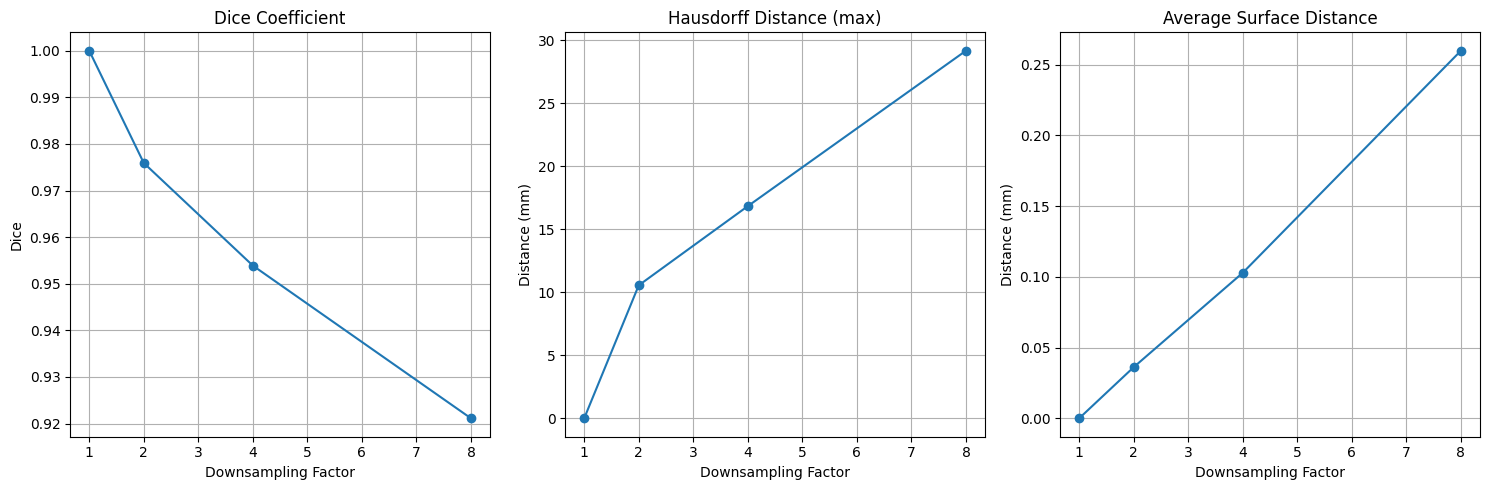

In [17]:


# Configurazione

github_raw_base = "https://raw.githubusercontent.com/noemicosma-commits/EICA_ROI_UMG_project/main/"

image_filename = "img1SL.nrrd"
label_filename = "img2SL.nrrd"

foreground_label = 1
downsample_factors = [1, 2, 4, 8]

# Download

def download_force(url, local_path):
    print(f"↓ Download: {url}")
    r = requests.get(url)
    r.raise_for_status()

    with open(local_path, "wb") as f:
        f.write(r.content)

    print(f"Salvato: {local_path}\n")


download_force(github_raw_base + image_filename, image_filename)
download_force(github_raw_base + label_filename, label_filename)

# Caricamento immagini

print("Lettura immagini...\n")

original_image = sitk.ReadImage(image_filename)
original_label = sitk.ReadImage(label_filename)



# Funzione Downsample + Upsample

def downsample_upsample(label, factor):

    if factor == 1:
        return label

    spacing = label.GetSpacing()
    size = label.GetSize()

    # Downsampling → aumento spacing
    new_spacing = tuple(s * factor for s in spacing)

    # Nuova dimensione
    new_size = tuple(
        max(1, int(round(sz * sp / nsp)))
        for sz, sp, nsp in zip(size, spacing, new_spacing)
    )

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputOrigin(label.GetOrigin())
    resampler.SetOutputDirection(label.GetDirection())
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)

    # Downsample
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    low_res = resampler.Execute(label)

    # Upsample back alla dimensione originale
    resampler.SetSize(size)
    resampler.SetOutputSpacing(spacing)
    restored = resampler.Execute(low_res)

    return restored


# Calcolo Metriche

results = []

for factor in downsample_factors:

    print(f"Processing factor {factor}...")

    restored_label = downsample_upsample(original_label, factor)
    pred = restored_label > 0

    # Se la struttura sparisce, salto Hausdorff
    if sitk.GetArrayFromImage(pred).sum() == 0:
        print(f"⚠ Foreground sparito per factor {factor}, skip\n")
        continue

    # Dice Coefficient
    overlap = sitk.LabelOverlapMeasuresImageFilter()
    overlap.Execute(gt, pred)
    dice = overlap.GetDiceCoefficient()

    # Hausdorff Distance
    haus = sitk.HausdorffDistanceImageFilter()
    haus.Execute(gt, pred)

    hd_max = haus.GetHausdorffDistance()
    hd_avg = haus.GetAverageHausdorffDistance()

    results.append({
        "factor": factor,
        "dice": dice,
        "hausdorff_max": hd_max,
        "avg_surface_distance": hd_avg
    })

# Risultati Tabellari

df = pd.DataFrame(results)

print("\n=============================")
print("RISULTATI FINALI")
print("=============================\n")
print(df)


# Plot

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Dice
axes[0].plot(df["factor"], df["dice"], marker="o")
axes[0].set_title("Dice Coefficient")
axes[0].set_xlabel("Downsampling Factor")
axes[0].set_ylabel("Dice")
axes[0].grid(True)

# Hausdorff massimo
axes[1].plot(df["factor"], df["hausdorff_max"], marker="o")
axes[1].set_title("Hausdorff Distance (max)")
axes[1].set_xlabel("Downsampling Factor")
axes[1].set_ylabel("Distance (mm)")
axes[1].grid(True)

# Average Surface Distance
axes[2].plot(df["factor"], df["avg_surface_distance"], marker="o")
axes[2].set_title("Average Surface Distance")
axes[2].set_xlabel("Downsampling Factor")
axes[2].set_ylabel("Distance (mm)")
axes[2].grid(True)

plt.tight_layout()
plt.show()




Visualizzo contorni per factor = 8


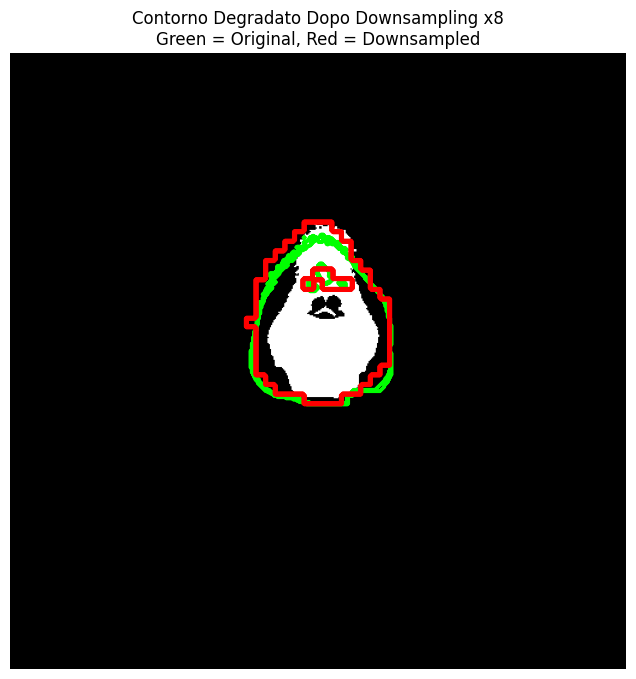

In [18]:

# Visualizzazione contorni su una slice (Label vera)


factor_to_show = 8  # massimo downsampling

print(f"\nVisualizzo contorni per factor = {factor_to_show}")

# Downsample + Upsample della label
restored_label = downsample_upsample(original_label, factor_to_show)

# Maschere binarie (sicurezza)
gt_mask = original_label > 0
pred_mask = restored_label > 0

# Estrazione contorni
gt_contour   = sitk.LabelContour(gt_mask)
pred_contour = sitk.LabelContour(pred_mask)

#Conversione numpy
img_np  = sitk.GetArrayFromImage(original_image)
gt_np   = sitk.GetArrayFromImage(gt_contour)
pred_np = sitk.GetArrayFromImage(pred_contour)

# Slice centrale
slice_index = img_np.shape[0] // 2

img_slice  = img_np[slice_index]
gt_slice   = gt_np[slice_index]
pred_slice = pred_np[slice_index]

plt.figure(figsize=(8,8))

plt.imshow(img_slice, cmap="gray")

# Contorno originale (verde)
plt.contour(gt_slice, colors="lime", linewidths=2)

# Contorno downsampled (rosso)
plt.contour(pred_slice, colors="red", linewidths=2)

plt.title(f"Contorno Degradato Dopo Downsampling x{factor_to_show}\n"
          f"Green = Original, Red = Downsampled")
plt.axis("off")
plt.show()



Confronto contorni sulla slice 53


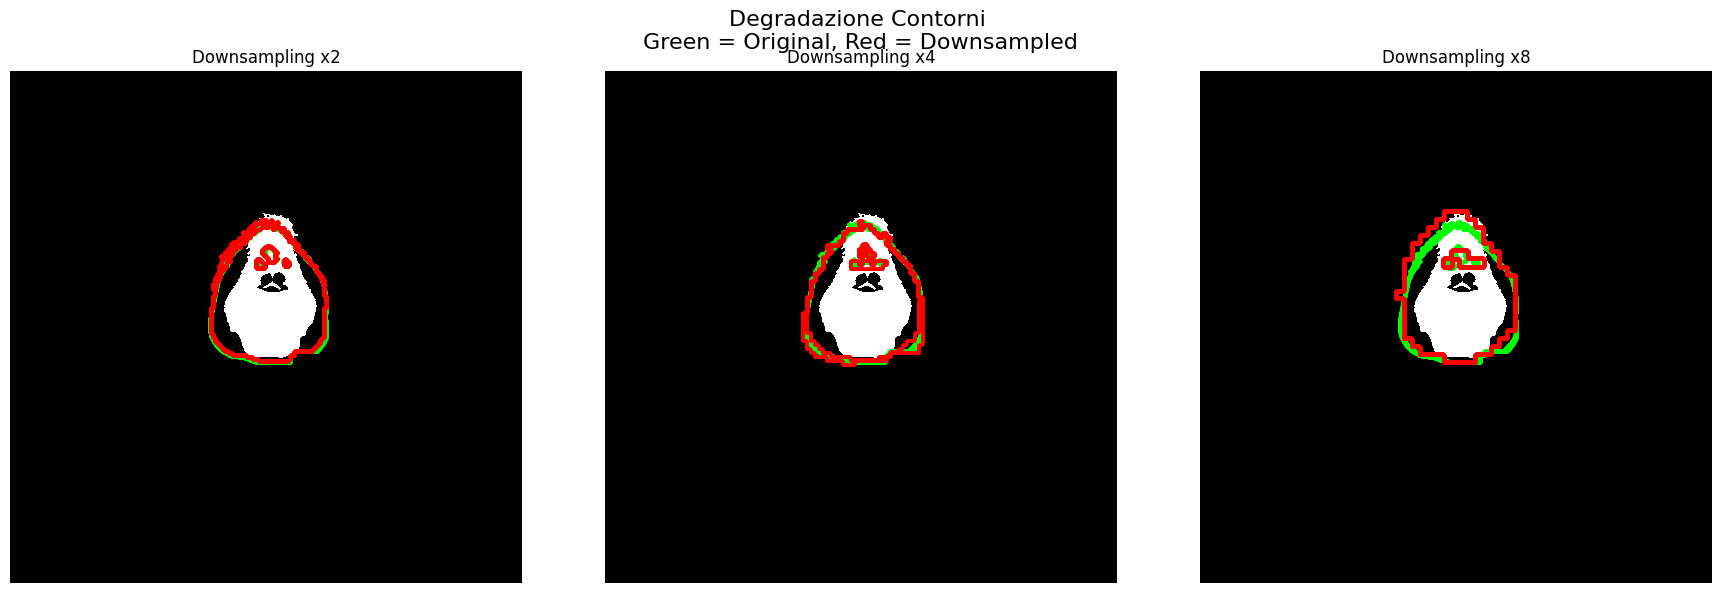

In [19]:

# Confronto su tutti i contorni


factors_to_show = [2, 4, 8]

img_np = sitk.GetArrayFromImage(original_image)


slice_idx = img_np.shape[0] // 2
img_slice = img_np[slice_idx]
print(f"\nConfronto contorni sulla slice {slice_idx}")

gt = original_label > 0

# Contorno originale
contour_gt = sitk.LabelContour(gt)
contour_gt_np = sitk.GetArrayFromImage(contour_gt)[slice_idx]

# Plot

fig, axes = plt.subplots(1, len(factors_to_show), figsize=(18, 6))

for i, factor in enumerate(factors_to_show):

    # Downsample + Upsample
    restored_label = downsample_upsample(original_label, factor)
    pred = restored_label > 0

    # Contorno degradato
    contour_pred = sitk.LabelContour(pred)
    contour_pred_np = sitk.GetArrayFromImage(contour_pred)[slice_idx]

    # Plot immagine base
    axes[i].imshow(img_slice, cmap="gray")

    # Contorno originale (verde)
    axes[i].contour(contour_gt_np, colors="lime", linewidths=2)

    # Contorno downsampled (rosso)
    axes[i].contour(contour_pred_np, colors="red", linewidths=2)

    axes[i].set_title(f"Downsampling x{factor}")
    axes[i].axis("off")

plt.suptitle(
    "Degradazione Contorni \nGreen = Original, Red = Downsampled",
    fontsize=16
)

plt.tight_layout()
plt.show()


In [20]:
# calcolo metriche
from sklearn.metrics import confusion_matrix

metrics_results = []

for factor in downsample_factors:

    resampled_label = downsample_upsample(original_label, factor)

    gt = original_label > 0
    pred = resampled_label > 0

    gt_flat = sitk.GetArrayFromImage(gt).ravel()
    pred_flat = sitk.GetArrayFromImage(pred).ravel()

    tn, fp, fn, tp = confusion_matrix(gt_flat, pred_flat, labels=[0, 1]).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    metrics_results.append({
        "Downsampling factor": factor,
        "Accuracy": accuracy,
        "Precision": precision,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "F1-score": f1_score
    })

metrics_df = pd.DataFrame(metrics_results)
metrics_df.iloc[:, 1:] = metrics_df.iloc[:, 1:].round(4)

display(metrics_df)


,Downsampling factor,Accuracy,Precision,Sensitivity,Specificity,F1-score
0,1,1.0000,1.0000,1.0000,1.0000,1.0000
1,2,0.9973,0.9770,0.9748,0.9986,0.9759
2,4,0.9948,0.9587,0.9492,0.9976,0.9539
3,8,0.9912,0.9285,0.9138,0.9958,0.9211
